In [159]:
#spacy
import spacy
import en_core_web_lg
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc, Span
from spacy.matcher import Matcher, PhraseMatcher


#gensim
import gensim
from gensim import corpora

#Visualization
from spacy import displacy
#import pyLDAvis.gensim_models
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#Data loading/ Data manipulation
import pandas as pd
import numpy as np
import jsonlines
import json
import os
import csv

#nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])

import time
#warning
import warnings 
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lewagonlew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lewagonlew/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
PATH = os.path.dirname(os.path.dirname(os.getcwd()))
PATH

'/home/lewagonlew/code/marcorodrigues/skills_matcher/skills_matcher'

In [45]:
nlp_ms = spacy.blank("en")
skill_pattern_path = PATH + "/data/dictionaries/complete_dict.jsonl"

ruler = nlp_ms.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp_ms.pipe_names

['entity_ruler']

In [8]:
#resume data from kaggle - for tryout

df = pd.read_csv(PATH + "/data/Resume/Resume.csv")
df.head()


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [ ]:
fig = px.histogram(
    df, x="Category", title="Distribution of Jobs Categories"
).update_xaxes(categoryorder="total descending")
fig.show()

In [46]:
df = df.reindex(np.random.permutation(df.index))
df = df.copy().iloc[
    0:200,
]
df.head()

,ID,Resume_str,Resume_html,Category,Clean_Resume,marked_text,skills
1047,17509935,SALES ASSOCIATE Summary Out...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale associate summary outgoing people oriente...,"(sale, associate, summary, outgoing, people, o...","[a, c, v, d, k, w, e, u, i, g, r, t, o, , s, ..."
612,15233524,DIRECTOR OF BUSINESS DEVELOPMENT ...,"<div class=""fontsize fontface vmargins hmargin...",BUSINESS-DEVELOPMENT,director business development highlight micros...,"(director, business, development, highlight, m...","[a, c, v, d, k, w, e, u, i, g, r, t, o, , s, ..."
981,24727739,QUALITY ASSURANCE LEAD Career O...,"<div class=""fontsize fontface vmargins hmargin...",BPO,quality assurance lead career overview coachin...,"(quality, assurance, lead, career, overview, c...","[a, c, v, d, k, w, e, u, i, g, r, t, o, , s, ..."
2482,21190805,PROGRAM DIRECTOR / OFFICE MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION,program director office manager summary highly...,"(program, director, office, manager, summary, ...","[a, c, v, d, k, w, e, u, i, g, r, t, o, , s, ..."
2011,12693146,SUPERINTENDANT Summary E...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,superintendant summary energetic construction ...,"(superintendant, summary, energetic, construct...","[a, c, v, d, k, w, e, u, i, g, r, t, o, , s, ..."


In [47]:
#different cleaning function

clean = []
for i in range(df.shape[0]):
    review = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
        " ",
        df["Resume_str"].iloc[i],
    )
    review = review.lower()
    review = review.split()
    lm = WordNetLemmatizer()
    review = [
        lm.lemmatize(word)
        for word in review
        if not word in set(stopwords.words("english"))
    ]
    review = " ".join(review)
    clean.append(review)

In [53]:
df["Clean_Resume"] = clean
df["marked_text"] = df["Clean_Resume"].str.lower().apply(nlp_ms)
df.head()

,ID,Resume_str,Resume_html,Category,Clean_Resume,marked_text,skills
1047,17509935,SALES ASSOCIATE Summary Out...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale associate summary outgoing people oriente...,"(sale, associate, summary, outgoing, people, o...","[business, schedule, schedule, schedule]"
612,15233524,DIRECTOR OF BUSINESS DEVELOPMENT ...,"<div class=""fontsize fontface vmargins hmargin...",BUSINESS-DEVELOPMENT,director business development highlight micros...,"(director, business, development, highlight, m...","[business, business, marketing, business, busi..."
981,24727739,QUALITY ASSURANCE LEAD Career O...,"<div class=""fontsize fontface vmargins hmargin...",BPO,quality assurance lead career overview coachin...,"(quality, assurance, lead, career, overview, c...","[support, material, monitoring, support, datab..."
2482,21190805,PROGRAM DIRECTOR / OFFICE MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION,program director office manager summary highly...,"(program, director, office, manager, summary, ...","[business, support, support, software, marketi..."
2011,12693146,SUPERINTENDANT Summary E...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,superintendant summary energetic construction ...,"(superintendant, summary, energetic, construct...","[design, documentation, marketing, schedule, p..."


In [68]:
df["skills"] = df["marked_text"].apply(create_skill_list)
df.reset_index(inplace = True)
df

ValueError: cannot insert level_0, already exists

In [70]:
df.drop(columns = ["level_0", "index", "ID"], inplace = True)

In [72]:
df["skills"][1]

{'business',
 'collaboration',
 'commerce',
 'database',
 'design',
 'impact',
 'marketing',
 'material',
 'monitoring',
 'support'}

In [38]:
set(flat_list)

{'accounting',
 'advertising',
 'business',
 'business administration',
 'commerce',
 'data analysis',
 'design',
 'documentation',
 'front end',
 'interaction',
 'marketing',
 'medium',
 'segment',
 'server',
 'support',
 'swift'}

In [18]:
test_resume = nlp_ms(df["Resume_str"].iloc[0])
resume_ents = [(ent.text, ent.label_) for ent in test_resume.ents]
displacy.render(test_resume, style="ent", jupyter=True)
print(resume_ents)

[('Project Management', 'SKILL|project-management'), ('Business', 'SKILL|business'), ('Business', 'SKILL|business'), ('Business', 'SKILL|business'), ('Business', 'SKILL|business'), ('Project management', 'SKILL|project-management'), ('Support', 'SKILL|support'), ('Business', 'SKILL|business'), ('Oracle', 'SKILL|oracle'), ('Oracle', 'SKILL|oracle'), ('support', 'SKILL|support'), ('schedule', 'SKILL|schedule'), ('Business', 'SKILL|business'), ('support', 'SKILL|support'), ('Business', 'SKILL|business'), ('Project Management', 'SKILL|project-management'), ('Business', 'SKILL|business'), ('Support', 'SKILL|support'), ('monitoring', 'SKILL|monitoring'), ('Business', 'SKILL|business'), ('Business', 'SKILL|business'), ('Business', 'SKILL|business'), ('Business', 'SKILL|business'), ('Support', 'SKILL|support'), ('Business', 'SKILL|business'), ('Finance', 'SKILL|finance'), ('CRM', 'SKILL|crm'), ('Project Management', 'SKILL|project-management'), ('communications', 'SKILL|communications'), ('Sup

In [57]:
test_list = create_skill_list(test_resume)
test_list

{'Business',
 'Business Administration',
 'C',
 'CRM',
 'Finance',
 'Oracle',
 'Project Management',
 'Project management',
 'Support',
 'communications',
 'monitoring',
 'schedule',
 'support'}

In [52]:
#functions for getting entities text, label, start and end of character position
def create_skill_set(doc):
    '''Create a set of the extracted skill entities of a doc'''
    #nlp_doc = nlp_ms(doc)
    return set([ent.label_.upper()[6:] for ent in doc.ents if 'skill' or 'knowledge' in ent.label_.lower()])

def create_skill_position(doc):
    '''Create a set of the extracted skill entities of a doc'''
    #nlp_doc = nlp_ms(doc)
    #[(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in sent.ents]
    return list([ent.start_char, ent.end_char, ent.label_] for ent in doc.ents )

#def create_skillset_dict(resume_texts):
#    '''Create a dictionary containing a set of the extracted skills. Name is key, matching skillset is value'''
#    skillsets = [create_skill_set(resume_text) for resume_text in resume_texts]
#   return skillsets

def create_skill_list(doc):
    t = list([ent.text] for ent in doc.ents )
    flat_list = [item for sublist in t for item in sublist]
    return set(flat_list)


In [137]:
def match_skills(JD_data_set, cv_set):
    '''Get intersection of resume skills and job offer skills and return match percentage'''
    pct_list = []
    
    if len(cv_set) < 1:
        print('could not extract skills from resume text')   
    else:
        #implement function comparing with a list of job_descriptions
        for i in range(0, len(JD_set)):
            match = cv_set & JD_set[i] 
            qu = len(cv_set & JD_set[i])
            di = len(JD_set[i])
            pct_match = round((qu/di) * 100, 2)
            pct_list.append([i, pct_match])
            
        pct_list.sort(key=lambda x: x[1], reverse = True)s
    
        #print("Resume has a {}% skill match on job offer".format(pct_match))
        #print('Required skills: {} '.format(JD_set))
        #print('Matched skills: {} \n'.format(JD_set.intersection(skillset_dict[resume_name])))
        
    return pct_list[0:9]

In [73]:
# compare df.skills with test_list
cv_set = test_list
JD_set = df.skills

In [136]:
df.head()

,Resume_str,Resume_html,Category,Clean_Resume,marked_text,skills
0,SALES ASSOCIATE Summary Out...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale associate summary outgoing people oriente...,"(sale, associate, summary, outgoing, people, o...","{schedule, business}"
1,DIRECTOR OF BUSINESS DEVELOPMENT ...,"<div class=""fontsize fontface vmargins hmargin...",BUSINESS-DEVELOPMENT,director business development highlight micros...,"(director, business, development, highlight, m...","{material, database, business, marketing, supp..."
2,QUALITY ASSURANCE LEAD Career O...,"<div class=""fontsize fontface vmargins hmargin...",BPO,quality assurance lead career overview coachin...,"(quality, assurance, lead, career, overview, c...","{material, documentation, engineering, box, da..."
3,PROGRAM DIRECTOR / OFFICE MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION,program director office manager summary highly...,"(program, director, office, manager, summary, ...","{material, medium, business, twitter, operatin..."
4,SUPERINTENDANT Summary E...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,superintendant summary energetic construction ...,"(superintendant, summary, energetic, construct...","{project management, documentation, material, ..."


In [138]:
pct_list = match_skills(JD_set, cv_set)

In [139]:
pct_list

[[96, 100.0],
 [111, 66.67],
 [169, 66.67],
 [95, 60.0],
 [0, 50.0],
 [19, 50.0],
 [20, 50.0],
 [37, 50.0],
 [52, 50.0]]

In [145]:
frame = pd.DataFrame

In [147]:
frame

In [155]:
job_number, matching_score, job_cat = [], [], []

for i in pct_list:
    #print(df["Category"][i[0]])
    print('Job #{} in Sector {} has a {}% match'.format(i[0], df["Category"][i[0]], i[1]))
    job_number.append(i[0])
    matching_score.append(i[1])
    job_cat.append(df["Category"][i[0]])
    
frame = pd.DataFrame(job_number, columns=['job_number'])
frame["matching_score"] = matching_score
frame["Category"] = df["Category"][i[0]]

Job #96 in Sector TEACHER has a 100.0% match
Job #111 in Sector TEACHER has a 66.67% match
Job #169 in Sector ADVOCATE has a 66.67% match
Job #95 in Sector APPAREL has a 60.0% match
Job #0 in Sector SALES has a 50.0% match
Job #19 in Sector HEALTHCARE has a 50.0% match
Job #20 in Sector TEACHER has a 50.0% match
Job #37 in Sector ADVOCATE has a 50.0% match
Job #52 in Sector TEACHER has a 50.0% match


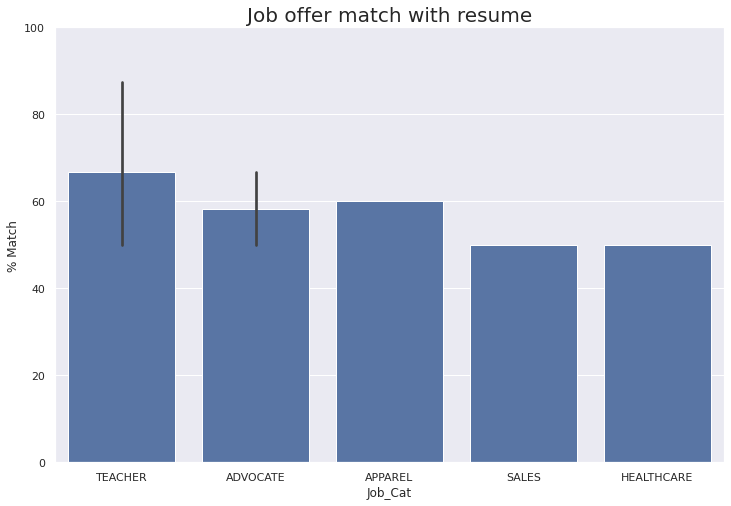

In [161]:
# Plotting
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Job offer match with resume', fontsize=20)
ax.set(xlabel='Job_Cat', ylabel='% Match')
ax.set(ylim=(0, 100))


sns.set(font_scale=1.5)
sns.barplot(x=list(job_cat), y=list(matching_score), color='b')

plt.show()

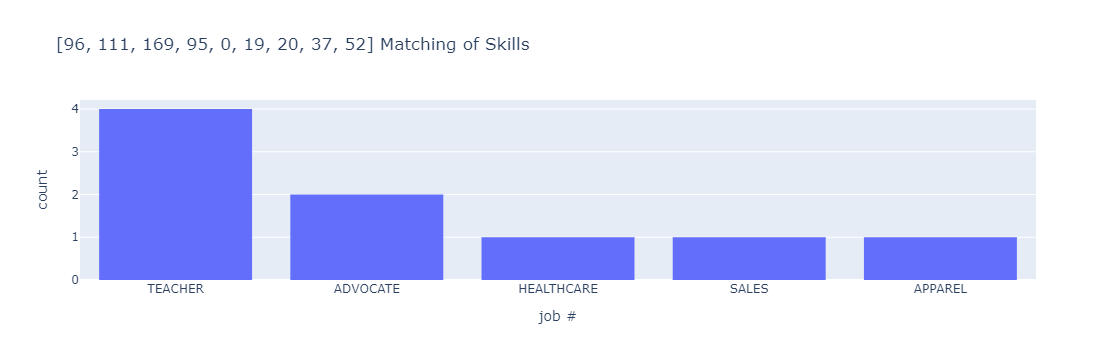

In [157]:
## compare list with data_set, visualize highest matching jobs

fig = px.histogram(
    x=job_cat,
    labels={"x": "job #"},
    title=f"{job_number} Matching of Skills",
).update_xaxes(categoryorder="total descending")
fig.show()

In [ ]:
## comparison of test_resume with automated_annotated_JD data

In [ ]:
print("Resume has a {}% skill match on job offer".format(pct_match))
print('Required skills: {} '.format(JD_set))
print('Matched skills: {} \n'.format(JD_set.intersection(skillset_dict[resume_name])))